In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
import random
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "centralized training_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.0,
    "learning_rate_TL": 0.0001,
    "batch_size_TL": 64,
    "decay_TL":1e-5,
    'num_rounds_TL': 40, 
    'epochs_TL': 100,
    'dropout_TL': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

transfer_i = random.randint(0, 3)
configuration  = dict(wandb.config)


def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.5):
    trainloader = []
    valloader = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        print(data.size())
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        print(data_resampled.shape)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        train_size = int(train_ratio * len(dataset))
        test_size = len(dataset) - train_size
        val_size = int(val_ratio * test_size)
        test_size = test_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        if i == transfer_i:
            trainloader_transfer = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valloader_transfer = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

        else:
            trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
            valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))
            
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, name):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        wandb.log({f'{name} training accuraccy': train_acc,
                  f'{name} validation accuracy': test_acc})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()

def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 50.09123992919922 Testing accuracy: 42.33576583862305.

Epoch 2/100
Epoch 2: Training accuracy: 52.6459846496582 Testing accuracy: 48.90510940551758.

Epoch 3/100
Epoch 3: Training accuracy: 53.55839538574219 Testing accuracy: 49.63503646850586.

Epoch 4/100
Epoch 4: Training accuracy: 62.40876007080078 Testing accuracy: 57.66423416137695.

Epoch 5/100
Epoch 5: Training accuracy: 63.41240692138672 Testing accuracy: 59.124088287353516.

Epoch 6/100
Epoch 6: Training accuracy: 65.87591552734375 Testing accuracy: 59.8540153503418.

Epoch 7/100
Epoch 7: Training accuracy: 67.60948944091797 Testing accuracy: 61.31386947631836.

Epoch 8/100
Epoch 8: Training accuracy: 68.70437622070312 Testing accuracy: 62.77372360229492.

Epoch 9/100
Epoch 9: Training accuracy: 69.06934356689453 Testing accuracy: 62.04379653930664.

Epoch 10/100
Epoch 10: Training accuracy: 66.69708251953125 Testing accuracy: 59.124088287353516.

Epoch 11/100
Epoch 11: Training accur

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


centralized training accuraccy,▁▂▄▄▅▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
centralized validation accuracy,▁▂▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██▇█████
centralized training accuraccy,91.24088
centralized validation accuracy,81.0219


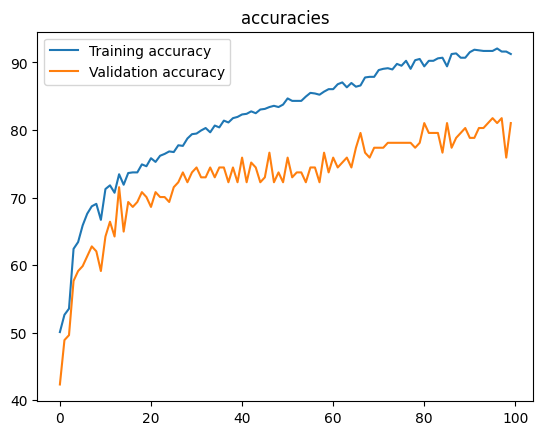

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'], name='centralized')
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

## Federated Learning

In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

torch.Size([1002, 4, 50])
(1670, 4, 50)
torch.Size([936, 4, 50])
(1560, 4, 50)
torch.Size([1242, 4, 50])
(2070, 4, 50)
torch.Size([1014, 4, 50])
(1690, 4, 50)


In [8]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "federated learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.0,
    "learning_rate_TL": 0.0001,
    "batch_size_TL": 64,
    "decay_TL":1e-5,
    'num_rounds_TL': 40, 
    'epochs_TL': 100,
    'dropout_TL': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [9]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [10]:
def train_FL(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()


In [11]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)
step = 0

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [13]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-17 21:12:19,620	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 54092040192.0, 'memory': 116214760448.0, 'node:192.168.1.146': 1.0, 'CPU': 32.0, 'GPU': 2.0, 'accelerator_type:G': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.06493556499481201 / accuracy 46.63805389404297
(ClientAppActor pid=403866) 
(ClientAppActor pid=403866) Epoch 1/100
(ClientAppActor pid=403866) Epoch 1: Training accuracy: 49.87922668457031 Testing accuracy: 55.55555725097656.
(ClientAppActor pid=403866) Epoch 2: Training accuracy: 49.87922668457031 Testing accuracy: 55.55555725097656.
(ClientAppActor pid=403866)  [repeated 26x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=403866) Epoch 17/100 [repeated 26x across cluster]
(ClientAppActor pid=403867) Epoch 12: Training accuracy: 50.67365264892578 Testing accuracy: 46.107784271240234. [repeated 30x across cluster]
(ClientAppActor pid=403866)  [repeated 51x across cluster]
(ClientAppActor pid=403866) Epoch 56/100 [repeated 51x across cluster]
(ClientAppActor pid=403866) Epoch 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.059781957756389274, {'accuracy': tensor(70.6724, device='cuda:0')}, 21.06122073000006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.059781957756389274 / accuracy 70.6723861694336
(ClientAppActor pid=403867)  [repeated 191x across cluster]
(ClientAppActor pid=403867) Epoch 19/100 [repeated 191x across cluster]
(ClientAppActor pid=403867) Epoch 51: Training accuracy: 71.556884765625 Testing accuracy: 70.65868377685547. [repeated 233x across cluster]
(ClientAppActor pid=403867)  [repeated 133x across cluster]
(ClientAppActor pid=403867) Epoch 92/100 [repeated 133x across cluster]
(ClientAppActor pid=403866) Epoch 75: Training accuracy: 73.00296020507812 Testing accuracy: 72.78106689453125. [repeated 82x across cluster]
(ClientAppActor pid=403866)  [repeated 43x across cluster]
(ClientAppActor pid=403866) Epoch 99/100 [repeated 43x across cluster]
(ClientAppActor pid=403867) Epoch 9: Training accuracy: 71.31642150878906 Testing accuracy: 75.36231994628906. [repeated 41x across cluster]
(ClientAppActor pid=403867)  [repeated 18x across cluster]
(ClientAppActor pid=403867) Epoch 23/100 [repe

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.05273230509324507, {'accuracy': tensor(72.2461, device='cuda:0')}, 40.38657671799956)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05273230509324507 / accuracy 72.24606323242188
(ClientAppActor pid=403867)  [repeated 152x across cluster]
(ClientAppActor pid=403867) Epoch 52/100 [repeated 152x across cluster]
(ClientAppActor pid=403867) Epoch 72: Training accuracy: 74.5772933959961 Testing accuracy: 76.32849884033203. [repeated 183x across cluster]
(ClientAppActor pid=403867)  [repeated 195x across cluster]
(ClientAppActor pid=403867) Epoch 70/100 [repeated 195x across cluster]
(ClientAppActor pid=403867) Epoch 71: Training accuracy: 73.2035903930664 Testing accuracy: 72.45509338378906. [repeated 158x across cluster]
(ClientAppActor pid=403867)  [repeated 11x across cluster]
(ClientAppActor pid=403867) Epoch 81/100 [repeated 11x across cluster]
(ClientAppActor pid=403867) Epoch 82: Training accuracy: 70.65868377685547 Testing accuracy: 67.6646728515625. [repeated 11x across cluster]
(ClientAppActor pid=403867)  [repeated 12x across cluster]
(ClientAppActor pid=403867) Epoch 93/100 [rep

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.051631694490259346, {'accuracy': tensor(72.2461, device='cuda:0')}, 61.60479454199958)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.051631694490259346 / accuracy 72.24606323242188


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=403866)  [repeated 43x across cluster]
(ClientAppActor pid=403866) Epoch 34/100 [repeated 43x across cluster]
(ClientAppActor pid=403867) Epoch 6: Training accuracy: 75.66425323486328 Testing accuracy: 74.87922668457031. [repeated 73x across cluster]
(ClientAppActor pid=403867)  [repeated 239x across cluster]
(ClientAppActor pid=403867) Epoch 97/100 [repeated 239x across cluster]
(ClientAppActor pid=403866) Epoch 95: Training accuracy: 74.1124267578125 Testing accuracy: 73.9645004272461. [repeated 228x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.05191037871620872, {'accuracy': tensor(71.6738, device='cuda:0')}, 70.12842795799952)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05191037871620872 / accuracy 71.67382049560547
(ClientAppActor pid=403866)  [repeated 47x across cluster]
(ClientAppActor pid=403866) Epoch 17/100 [repeated 47x across cluster]
(ClientAppActor pid=403866) Epoch 21: Training accuracy: 73.2784423828125 Testing accuracy: 74.25149536132812. [repeated 32x across cluster]
(ClientAppActor pid=403867)  [repeated 34x across cluster]
(ClientAppActor pid=403867) Epoch 15/100 [repeated 34x across cluster]
(ClientAppActor pid=403866) Epoch 47: Training accuracy: 73.95209503173828 Testing accuracy: 75.44910430908203. [repeated 35x across cluster]
(ClientAppActor pid=403866)  [repeated 68x across cluster]
(ClientAppActor pid=403866) Epoch 95/100 [repeated 68x across cluster]
(ClientAppActor pid=403867) Epoch 41: Training accuracy: 75.12077331542969 Testing accuracy: 75.36231994628906. [repeated 106x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.05232052369551225, {'accuracy': tensor(70.8155, device='cuda:0')}, 86.74632144100178)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05232052369551225 / accuracy 70.8154525756836
(ClientAppActor pid=403866)  [repeated 223x across cluster]
(ClientAppActor pid=403866) Epoch 12/100 [repeated 223x across cluster]
(ClientAppActor pid=403866) Epoch 16: Training accuracy: 75.48309326171875 Testing accuracy: 74.87922668457031. [repeated 186x across cluster]
(ClientAppActor pid=403866)  [repeated 45x across cluster]
(ClientAppActor pid=403866) Epoch 44/100 [repeated 45x across cluster]
(ClientAppActor pid=403866) Epoch 53: Training accuracy: 75.84541320800781 Testing accuracy: 76.81159210205078. [repeated 49x across cluster]
(ClientAppActor pid=403867)  [repeated 60x across cluster]
(ClientAppActor pid=403867) Epoch 60/100 [repeated 60x across cluster]
(ClientAppActor pid=403866) Epoch 13: Training accuracy: 75.59171295166016 Testing accuracy: 75.7396469116211. [repeated 71x across cluster]
(ClientAppActor pid=403867)  [repeated 125x across cluster]
(ClientAppActor pid=403867) Epoch 77/100 [repe

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (6, 0.0528517636385831, {'accuracy': tensor(72.1030, device='cuda:0')}, 105.75990144200114)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0528517636385831 / accuracy 72.1030044555664
(ClientAppActor pid=403867)  [repeated 167x across cluster]
(ClientAppActor pid=403867) Epoch 72/100 [repeated 167x across cluster]
(ClientAppActor pid=403866) Epoch 3: Training accuracy: 73.50299072265625 Testing accuracy: 75.44910430908203. [repeated 220x across cluster]
(ClientAppActor pid=403866)  [repeated 80x across cluster]
(ClientAppActor pid=403866) Epoch 24/100 [repeated 80x across cluster]
(ClientAppActor pid=403866) Epoch 29: Training accuracy: 74.62574768066406 Testing accuracy: 72.45509338378906. [repeated 26x across cluster]
(ClientAppActor pid=403866)  [repeated 30x across cluster]
(ClientAppActor pid=403866) Epoch 54/100 [repeated 30x across cluster]
(ClientAppActor pid=403866) Epoch 87: Training accuracy: 74.85029602050781 Testing accuracy: 76.04790496826172. [repeated 58x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (7, 0.053121897307309235, {'accuracy': tensor(70.6724, device='cuda:0')}, 120.50783652099926)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053121897307309235 / accuracy 70.6723861694336
(ClientAppActor pid=403866)  [repeated 113x across cluster]
(ClientAppActor pid=403866) Epoch 60/100 [repeated 113x across cluster]
(ClientAppActor pid=403866) Epoch 83: Training accuracy: 74.75845336914062 Testing accuracy: 75.84541320800781. [repeated 105x across cluster]
(ClientAppActor pid=403867)  [repeated 149x across cluster]
(ClientAppActor pid=403867) Epoch 45/100 [repeated 149x across cluster]
(ClientAppActor pid=403867) Epoch 65: Training accuracy: 73.2784423828125 Testing accuracy: 77.84431457519531. [repeated 173x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (8, 0.05350592461499301, {'accuracy': tensor(70.3863, device='cuda:0')}, 131.06346793500052)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05350592461499301 / accuracy 70.38626861572266
(ClientAppActor pid=403867)  [repeated 197x across cluster]
(ClientAppActor pid=403867) Epoch 68/100 [repeated 197x across cluster]
(ClientAppActor pid=403867) Epoch 71: Training accuracy: 75.29940032958984 Testing accuracy: 73.05389404296875. [repeated 157x across cluster]
(ClientAppActor pid=403866)  [repeated 47x across cluster]
(ClientAppActor pid=403866) Epoch 79/100 [repeated 47x across cluster]
(ClientAppActor pid=403866) Epoch 92: Training accuracy: 75.44378662109375 Testing accuracy: 75.1479263305664. [repeated 53x across cluster]
(ClientAppActor pid=403866)  [repeated 58x across cluster]
(ClientAppActor pid=403866) Epoch 26/100 [repeated 58x across cluster]
(ClientAppActor pid=403866) Epoch 36: Training accuracy: 76.50965881347656 Testing accuracy: 76.32849884033203. [repeated 55x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (9, 0.05349561301144687, {'accuracy': tensor(71.1016, device='cuda:0')}, 148.61873203399955)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05349561301144687 / accuracy 71.10157012939453
(ClientAppActor pid=403866)  [repeated 89x across cluster]
(ClientAppActor pid=403866) Epoch 6/100 [repeated 89x across cluster]
(ClientAppActor pid=403866) Epoch 27: Training accuracy: 77.23429870605469 Testing accuracy: 76.81159210205078. [repeated 99x across cluster]
(ClientAppActor pid=403866)  [repeated 105x across cluster]
(ClientAppActor pid=403866) Epoch 100/100 [repeated 105x across cluster]
(ClientAppActor pid=403867) Epoch 25: Training accuracy: 74.70059967041016 Testing accuracy: 76.04790496826172. [repeated 120x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (10, 0.053595868023959076, {'accuracy': tensor(71.6738, device='cuda:0')}, 159.14087649000066)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


(ClientAppActor pid=403867)  [repeated 183x across cluster]
(ClientAppActor pid=403867) Epoch 95/100 [repeated 183x across cluster]
Server-side evaluation loss 0.053595868023959076 / accuracy 71.67382049560547


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=403867) Epoch 33: Training accuracy: 74.40119934082031 Testing accuracy: 72.45509338378906. [repeated 207x across cluster]
(ClientAppActor pid=403866)  [repeated 197x across cluster]
(ClientAppActor pid=403866) Epoch 79/100 [repeated 197x across cluster]
(ClientAppActor pid=403866) Epoch 84: Training accuracy: 77.5147933959961 Testing accuracy: 73.9645004272461. [repeated 142x across cluster]
(ClientAppActor pid=403867)  [repeated 32x across cluster]
(ClientAppActor pid=403867) Epoch 24/100 [repeated 32x across cluster]
(ClientAppActor pid=403867) Epoch 25: Training accuracy: 75.24154663085938 Testing accuracy: 75.84541320800781. [repeated 27x across cluster]
(ClientAppActor pid=403867)  [repeated 10x across cluster]
(ClientAppActor pid=403867) Epoch 34/100 [repeated 10x across cluster]
(ClientAppActor pid=403867) Epoch 35: Training accuracy: 76.87197875976562 Testing accuracy: 76.81159210205078. [repeated 10x across cluster]
(ClientAppActor pid=403867)  [repeated 1

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (11, 0.05412781238555908, {'accuracy': tensor(70.1001, device='cuda:0')}, 182.85759214200152)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05412781238555908 / accuracy 70.10014343261719
(ClientAppActor pid=403867)  [repeated 149x across cluster]
(ClientAppActor pid=403867) Epoch 56/100 [repeated 149x across cluster]
(ClientAppActor pid=403866) Epoch 50: Training accuracy: 76.19760131835938 Testing accuracy: 74.85029602050781. [repeated 153x across cluster]
(ClientAppActor pid=403867)  [repeated 46x across cluster]
(ClientAppActor pid=403867) Epoch 76/100 [repeated 46x across cluster]
(ClientAppActor pid=403866) Epoch 76: Training accuracy: 76.57185363769531 Testing accuracy: 77.84431457519531. [repeated 38x across cluster]
(ClientAppActor pid=403867)  [repeated 42x across cluster]
(ClientAppActor pid=403867) Epoch 88/100 [repeated 42x across cluster]
(ClientAppActor pid=403867) Epoch 90: Training accuracy: 76.0354995727539 Testing accuracy: 74.55621337890625. [repeated 41x across cluster]
(ClientAppActor pid=403866)  [repeated 52x across cluster]
(ClientAppActor pid=403866) Epoch 41/100 [repe

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (12, 0.05378336798061024, {'accuracy': tensor(71.9599, device='cuda:0')}, 202.36703666800167)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05378336798061024 / accuracy 71.95994567871094
(ClientAppActor pid=403867)  [repeated 153x across cluster]
(ClientAppActor pid=403867) Epoch 14/100 [repeated 153x across cluster]
(ClientAppActor pid=403867) Epoch 27: Training accuracy: 77.07100677490234 Testing accuracy: 76.92308044433594. [repeated 175x across cluster]
(ClientAppActor pid=403867)  [repeated 186x across cluster]
(ClientAppActor pid=403867) Epoch 79/100 [repeated 186x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (13, 0.054018600420518356, {'accuracy': tensor(70.9585, device='cuda:0')}, 211.170020906)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=403867) Epoch 95: Training accuracy: 78.4023666381836 Testing accuracy: 73.9645004272461. [repeated 156x across cluster]
Server-side evaluation loss 0.054018600420518356 / accuracy 70.95851135253906
(ClientAppActor pid=403867)  [repeated 238x across cluster]
(ClientAppActor pid=403867) Epoch 20/100 [repeated 238x across cluster]
(ClientAppActor pid=403867) Epoch 34: Training accuracy: 77.59661865234375 Testing accuracy: 77.29468536376953. [repeated 239x across cluster]
(ClientAppActor pid=403867)  [repeated 25x across cluster]
(ClientAppActor pid=403867) Epoch 42/100 [repeated 25x across cluster]
(ClientAppActor pid=403867) Epoch 44: Training accuracy: 77.71739196777344 Testing accuracy: 77.29468536376953. [repeated 10x across cluster]
(ClientAppActor pid=403867)  [repeated 9x across cluster]
(ClientAppActor pid=403867) Epoch 51/100 [repeated 9x across cluster]
(ClientAppActor pid=403867) Epoch 53: Training accuracy: 77.59661865234375 Testing accuracy: 77.7777786254

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (14, 0.05436120250008323, {'accuracy': tensor(71.1016, device='cuda:0')}, 235.89106455799993)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05436120250008323 / accuracy 71.10157012939453
(ClientAppActor pid=403867) Epoch 32: Training accuracy: 76.5700454711914 Testing accuracy: 77.29468536376953. [repeated 104x across cluster]
(ClientAppActor pid=403866)  [repeated 164x across cluster]
(ClientAppActor pid=403866) Epoch 73/100 [repeated 164x across cluster]
(ClientAppActor pid=403866) Epoch 82: Training accuracy: 76.6467056274414 Testing accuracy: 76.04790496826172. [repeated 92x across cluster]
(ClientAppActor pid=403866)  [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 100/100 [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 13: Training accuracy: 77.5147933959961 Testing accuracy: 75.7396469116211. [repeated 40x across cluster]
(ClientAppActor pid=403866)  [repeated 87x across cluster]
(ClientAppActor pid=403866) Epoch 78/100 [repeated 87x across cluster]
(ClientAppActor pid=403867) Epoch 96: Training accuracy: 76.99275207519531 Testing accuracy: 77.77777862548

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (15, 0.05465879765423862, {'accuracy': tensor(70.3863, device='cuda:0')}, 254.6697178409995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)


Server-side evaluation loss 0.05465879765423862 / accuracy 70.38626861572266


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=403867)  [repeated 49x across cluster]
(ClientAppActor pid=403867) Epoch 2/100 [repeated 49x across cluster]
(ClientAppActor pid=403867) Epoch 6: Training accuracy: 77.29290008544922 Testing accuracy: 75.1479263305664. [repeated 82x across cluster]
(ClientAppActor pid=403867)  [repeated 223x across cluster]
(ClientAppActor pid=403867) Epoch 91/100 [repeated 223x across cluster]
(ClientAppActor pid=403866) Epoch 93: Training accuracy: 77.17391204833984 Testing accuracy: 78.74396514892578. [repeated 215x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (16, 0.054056340997869316, {'accuracy': tensor(71.9599, device='cuda:0')}, 264.2711434060002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054056340997869316 / accuracy 71.95994567871094
(ClientAppActor pid=403866)  [repeated 66x across cluster]
(ClientAppActor pid=403866) Epoch 7/100 [repeated 66x across cluster]
(ClientAppActor pid=403866) Epoch 21: Training accuracy: 76.49700927734375 Testing accuracy: 74.25149536132812. [repeated 33x across cluster]
(ClientAppActor pid=403866)  [repeated 61x across cluster]
(ClientAppActor pid=403866) Epoch 58/100 [repeated 61x across cluster]
(ClientAppActor pid=403866) Epoch 81: Training accuracy: 77.76946258544922 Testing accuracy: 75.44910430908203. [repeated 69x across cluster]
(ClientAppActor pid=403867)  [repeated 107x across cluster]
(ClientAppActor pid=403867) Epoch 21/100 [repeated 107x across cluster]
(ClientAppActor pid=403867) Epoch 24: Training accuracy: 77.47584533691406 Testing accuracy: 78.74396514892578. [repeated 129x across cluster]
(ClientAppActor pid=403867)  [repeated 60x across cluster]
(ClientAppActor pid=403867) Epoch 37/100 [rep

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (17, 0.05445396358316595, {'accuracy': tensor(70.8155, device='cuda:0')}, 283.78020718100015)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05445396358316595 / accuracy 70.8154525756836
(ClientAppActor pid=403867)  [repeated 141x across cluster]
(ClientAppActor pid=403867) Epoch 51/100 [repeated 141x across cluster]
(ClientAppActor pid=403867) Epoch 58: Training accuracy: 77.17066192626953 Testing accuracy: 76.04790496826172. [repeated 113x across cluster]
(ClientAppActor pid=403866)  [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 50/100 [repeated 37x across cluster]
(ClientAppActor pid=403867) Epoch 70: Training accuracy: 77.09580993652344 Testing accuracy: 77.84431457519531. [repeated 33x across cluster]
(ClientAppActor pid=403866)  [repeated 32x across cluster]
(ClientAppActor pid=403866) Epoch 71/100 [repeated 32x across cluster]
(ClientAppActor pid=403866) Epoch 80: Training accuracy: 74.87922668457031 Testing accuracy: 75.36231994628906. [repeated 33x across cluster]
(ClientAppActor pid=403866)  [repeated 43x across cluster]
(ClientAppActor pid=403866) Epoch 2/100 [repea

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (18, 0.054393210194327614, {'accuracy': tensor(71.3877, device='cuda:0')}, 305.2426167720005)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054393210194327614 / accuracy 71.3876953125
(ClientAppActor pid=403867)  [repeated 147x across cluster]
(ClientAppActor pid=403867) Epoch 13/100 [repeated 147x across cluster]
(ClientAppActor pid=403867) Epoch 86: Training accuracy: 78.14009857177734 Testing accuracy: 78.26087188720703. [repeated 241x across cluster]
(ClientAppActor pid=403866)  [repeated 196x across cluster]
(ClientAppActor pid=403866) Epoch 33/100 [repeated 196x across cluster]
(ClientAppActor pid=403866) Epoch 43: Training accuracy: 78.25444030761719 Testing accuracy: 76.33135986328125. [repeated 64x across cluster]
(ClientAppActor pid=403866)  [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 70/100 [repeated 37x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (19, 0.05446942827918313, {'accuracy': tensor(71.3877, device='cuda:0')}, 318.57595005500116)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=403866) Epoch 100: Training accuracy: 78.69822692871094 Testing accuracy: 75.1479263305664. [repeated 57x across cluster]
Server-side evaluation loss 0.05446942827918313 / accuracy 71.3876953125
(ClientAppActor pid=403866)  [repeated 67x across cluster]
(ClientAppActor pid=403866) Epoch 33/100 [repeated 67x across cluster]
(ClientAppActor pid=403867) Epoch 9: Training accuracy: 76.81159210205078 Testing accuracy: 78.26087188720703. [repeated 103x across cluster]
(ClientAppActor pid=403866)  [repeated 150x across cluster]
(ClientAppActor pid=403866) Epoch 70/100 [repeated 150x across cluster]
(ClientAppActor pid=403867) Epoch 39: Training accuracy: 79.28743743896484 Testing accuracy: 78.26087188720703. [repeated 136x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (20, 0.05512780492955988, {'accuracy': tensor(70.3863, device='cuda:0')}, 330.70678191299885)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05512780492955988 / accuracy 70.38626861572266
(ClientAppActor pid=403867)  [repeated 127x across cluster]
(ClientAppActor pid=403867) Epoch 9/100 [repeated 127x across cluster]
(ClientAppActor pid=403867) Epoch 41: Training accuracy: 77.17066192626953 Testing accuracy: 78.443115234375. [repeated 125x across cluster]
(ClientAppActor pid=403866)  [repeated 69x across cluster]
(ClientAppActor pid=403866) Epoch 36/100 [repeated 69x across cluster]
(ClientAppActor pid=403867) Epoch 53: Training accuracy: 78.29341125488281 Testing accuracy: 75.44910430908203. [repeated 36x across cluster]
(ClientAppActor pid=403866)  [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 61/100 [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 94: Training accuracy: 78.32839965820312 Testing accuracy: 75.7396469116211. [repeated 58x across cluster]
(ClientAppActor pid=403867)  [repeated 68x across cluster]
(ClientAppActor pid=403867) Epoch 71/100 [repeate

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (21, 0.054405808448791504, {'accuracy': tensor(71.1016, device='cuda:0')}, 353.3204510450014)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054405808448791504 / accuracy 71.10157012939453
(ClientAppActor pid=403867) Epoch 11: Training accuracy: 77.59661865234375 Testing accuracy: 79.22705078125. [repeated 102x across cluster]
(ClientAppActor pid=403867)  [repeated 199x across cluster]
(ClientAppActor pid=403867) Epoch 78/100 [repeated 199x across cluster]
(ClientAppActor pid=403866) Epoch 13: Training accuracy: 78.77218627929688 Testing accuracy: 78.10650634765625. [repeated 192x across cluster]
(ClientAppActor pid=403866)  [repeated 66x across cluster]
(ClientAppActor pid=403866) Epoch 24/100 [repeated 66x across cluster]
(ClientAppActor pid=403866) Epoch 36: Training accuracy: 77.6627197265625 Testing accuracy: 76.33135986328125. [repeated 23x across cluster]
(ClientAppActor pid=403866)  [repeated 23x across cluster]
(ClientAppActor pid=403866) Epoch 47/100 [repeated 23x across cluster]
(ClientAppActor pid=403866) Epoch 58: Training accuracy: 78.47633361816406 Testing accuracy: 76.9230804443

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (22, 0.05480491031299938, {'accuracy': tensor(70.9585, device='cuda:0')}, 372.3845185730024)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05480491031299938 / accuracy 70.95851135253906
(ClientAppActor pid=403867) Epoch 6: Training accuracy: 76.34730529785156 Testing accuracy: 75.44910430908203. [repeated 90x across cluster]
(ClientAppActor pid=403867)  [repeated 160x across cluster]
(ClientAppActor pid=403867) Epoch 27/100 [repeated 160x across cluster]
(ClientAppActor pid=403867) Epoch 64: Training accuracy: 78.21855926513672 Testing accuracy: 74.85029602050781. [repeated 216x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (23, 0.054708475416356865, {'accuracy': tensor(71.1016, device='cuda:0')}, 380.6023437170006)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054708475416356865 / accuracy 71.10157012939453
(ClientAppActor pid=403867)  [repeated 217x across cluster]
(ClientAppActor pid=403867) Epoch 27/100 [repeated 217x across cluster]
(ClientAppActor pid=403867) Epoch 72: Training accuracy: 79.46859741210938 Testing accuracy: 79.71014404296875. [repeated 169x across cluster]
(ClientAppActor pid=403866)  [repeated 102x across cluster]
(ClientAppActor pid=403866) Epoch 76/100 [repeated 102x across cluster]
(ClientAppActor pid=403866) Epoch 89: Training accuracy: 80.1775131225586 Testing accuracy: 78.69822692871094. [repeated 37x across cluster]
(ClientAppActor pid=403867)  [repeated 38x across cluster]
(ClientAppActor pid=403867) Epoch 91/100 [repeated 38x across cluster]
(ClientAppActor pid=403867) Epoch 99: Training accuracy: 79.52898406982422 Testing accuracy: 79.22705078125. [repeated 42x across cluster]
(ClientAppActor pid=403866)  [repeated 57x across cluster]
(ClientAppActor pid=403866) Epoch 48/100 [repe

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (24, 0.05562719431790439, {'accuracy': tensor(70.5293, device='cuda:0')}, 398.7033154620003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05562719431790439 / accuracy 70.52932739257812
(ClientAppActor pid=403866) Epoch 12: Training accuracy: 79.34782409667969 Testing accuracy: 79.22705078125. [repeated 102x across cluster]
(ClientAppActor pid=403867)  [repeated 136x across cluster]
(ClientAppActor pid=403867) Epoch 25/100 [repeated 136x across cluster]
(ClientAppActor pid=403867) Epoch 58: Training accuracy: 79.73372650146484 Testing accuracy: 78.10650634765625. [repeated 169x across cluster]
(ClientAppActor pid=403867)  [repeated 203x across cluster]
(ClientAppActor pid=403867) Epoch 96/100 [repeated 203x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (25, 0.05474663322622126, {'accuracy': tensor(71.1016, device='cuda:0')}, 406.99268935000146)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05474663322622126 / accuracy 71.10157012939453
(ClientAppActor pid=403867) Epoch 75: Training accuracy: 75.67365264892578 Testing accuracy: 72.45509338378906. [repeated 241x across cluster]
(ClientAppActor pid=403867)  [repeated 209x across cluster]
(ClientAppActor pid=403867) Epoch 17/100 [repeated 209x across cluster]
(ClientAppActor pid=403867) Epoch 22: Training accuracy: 78.8043441772461 Testing accuracy: 79.22705078125. [repeated 88x across cluster]
(ClientAppActor pid=403867)  [repeated 32x across cluster]
(ClientAppActor pid=403867) Epoch 28/100 [repeated 32x across cluster]
(ClientAppActor pid=403867) Epoch 32: Training accuracy: 78.44203186035156 Testing accuracy: 79.22705078125. [repeated 20x across cluster]
(ClientAppActor pid=403867)  [repeated 10x across cluster]
(ClientAppActor pid=403867) Epoch 38/100 [repeated 10x across cluster]
(ClientAppActor pid=403867) Epoch 42: Training accuracy: 79.34782409667969 Testing accuracy: 78.74396514892578.

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (26, 0.053625507788224655, {'accuracy': tensor(73.6767, device='cuda:0')}, 435.9324788410013)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053625507788224655 / accuracy 73.67668151855469
(ClientAppActor pid=403867)  [repeated 128x across cluster]
(ClientAppActor pid=403867) Epoch 44/100 [repeated 128x across cluster]
(ClientAppActor pid=403867) Epoch 74: Training accuracy: 79.89130401611328 Testing accuracy: 79.71014404296875. [repeated 158x across cluster]
(ClientAppActor pid=403866)  [repeated 74x across cluster]
(ClientAppActor pid=403866) Epoch 81/100 [repeated 74x across cluster]
(ClientAppActor pid=403867) Epoch 84: Training accuracy: 80.13285064697266 Testing accuracy: 79.22705078125. [repeated 35x across cluster]
(ClientAppActor pid=403867)  [repeated 39x across cluster]
(ClientAppActor pid=403867) Epoch 96/100 [repeated 39x across cluster]
(ClientAppActor pid=403866) Epoch 23: Training accuracy: 78.32839965820312 Testing accuracy: 77.5147933959961. [repeated 47x across cluster]
(ClientAppActor pid=403866)  [repeated 72x across cluster]
(ClientAppActor pid=403866) Epoch 72/100 [repeat

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (27, 0.05371668122031472, {'accuracy': tensor(73.6767, device='cuda:0')}, 453.8048336280008)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05371668122031472 / accuracy 73.67668151855469
(ClientAppActor pid=403867) Epoch 17: Training accuracy: 79.26646423339844 Testing accuracy: 76.04790496826172. [repeated 118x across cluster]
(ClientAppActor pid=403867)  [repeated 197x across cluster]
(ClientAppActor pid=403867) Epoch 98/100 [repeated 197x across cluster]
(ClientAppActor pid=403867) Epoch 50: Training accuracy: 79.73372650146484 Testing accuracy: 79.2899398803711. [repeated 207x across cluster]
(ClientAppActor pid=403867)  [repeated 89x across cluster]
(ClientAppActor pid=403867) Epoch 58/100 [repeated 89x across cluster]
(ClientAppActor pid=403867) Epoch 63: Training accuracy: 78.99407958984375 Testing accuracy: 74.55621337890625. [repeated 15x across cluster]
(ClientAppActor pid=403867)  [repeated 12x across cluster]
(ClientAppActor pid=403867) Epoch 70/100 [repeated 12x across cluster]
(ClientAppActor pid=403867) Epoch 74: Training accuracy: 78.99407958984375 Testing accuracy: 77.51479339

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (28, 0.05365835536609997, {'accuracy': tensor(73.2475, device='cuda:0')}, 476.34300829100175)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05365835536609997 / accuracy 73.24749755859375
(ClientAppActor pid=403867)  [repeated 83x across cluster]
(ClientAppActor pid=403867) Epoch 45/100 [repeated 83x across cluster]
(ClientAppActor pid=403867) Epoch 12: Training accuracy: 78.77218627929688 Testing accuracy: 74.55621337890625. [repeated 174x across cluster]
(ClientAppActor pid=403867)  [repeated 208x across cluster]
(ClientAppActor pid=403867) Epoch 78/100 [repeated 208x across cluster]
(ClientAppActor pid=403867) Epoch 86: Training accuracy: 80.39940643310547 Testing accuracy: 77.5147933959961. [repeated 118x across cluster]
(ClientAppActor pid=403867)  [repeated 20x across cluster]
(ClientAppActor pid=403867) Epoch 93/100 [repeated 20x across cluster]
(ClientAppActor pid=403867) Epoch 98: Training accuracy: 79.65975952148438 Testing accuracy: 76.92308044433594. [repeated 12x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (29, 0.05583605441180142, {'accuracy': tensor(70.8155, device='cuda:0')}, 492.562496843002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05583605441180142 / accuracy 70.8154525756836
(ClientAppActor pid=403867)  [repeated 19x across cluster]
(ClientAppActor pid=403867) Epoch 3/100 [repeated 19x across cluster]
(ClientAppActor pid=403866) Epoch 72: Training accuracy: 78.84615325927734 Testing accuracy: 77.5147933959961. [repeated 82x across cluster]
(ClientAppActor pid=403866)  [repeated 119x across cluster]
(ClientAppActor pid=403866) Epoch 17/100 [repeated 119x across cluster]
(ClientAppActor pid=403866) Epoch 68: Training accuracy: 79.89130401611328 Testing accuracy: 80.1932373046875. [repeated 107x across cluster]
(ClientAppActor pid=403867)  [repeated 98x across cluster]
(ClientAppActor pid=403867) Epoch 29/100 [repeated 98x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (30, 0.054285759275609795, {'accuracy': tensor(72.2461, device='cuda:0')}, 506.6097426180022)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054285759275609795 / accuracy 72.24606323242188
(ClientAppActor pid=403867) Epoch 100: Training accuracy: 80.76347351074219 Testing accuracy: 77.2455062866211. [repeated 113x across cluster]
(ClientAppActor pid=403867)  [repeated 174x across cluster]
(ClientAppActor pid=403867) Epoch 64/100 [repeated 174x across cluster]
(ClientAppActor pid=403866) Epoch 52: Training accuracy: 80.02958679199219 Testing accuracy: 77.5147933959961. [repeated 138x across cluster]
(ClientAppActor pid=403866)  [repeated 52x across cluster]
(ClientAppActor pid=403866) Epoch 62/100 [repeated 52x across cluster]
(ClientAppActor pid=403867) Epoch 100: Training accuracy: 80.83832550048828 Testing accuracy: 79.04191589355469. [repeated 34x across cluster]
(ClientAppActor pid=403866)  [repeated 33x across cluster]
(ClientAppActor pid=403866) Epoch 83/100 [repeated 33x across cluster]
(ClientAppActor pid=403866) Epoch 96: Training accuracy: 79.80769348144531 Testing accuracy: 76.923080

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (31, 0.054772897200150925, {'accuracy': tensor(72.2461, device='cuda:0')}, 532.8955112110016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054772897200150925 / accuracy 72.24606323242188
(ClientAppActor pid=403867)  [repeated 107x across cluster]
(ClientAppActor pid=403867) Epoch 27/100 [repeated 107x across cluster]
(ClientAppActor pid=403866) Epoch 24: Training accuracy: 78.29341125488281 Testing accuracy: 77.84431457519531. [repeated 67x across cluster]
(ClientAppActor pid=403866)  [repeated 51x across cluster]
(ClientAppActor pid=403866) Epoch 48/100 [repeated 51x across cluster]
(ClientAppActor pid=403866) Epoch 79: Training accuracy: 80.83832550048828 Testing accuracy: 76.04790496826172. [repeated 67x across cluster]
(ClientAppActor pid=403866)  [repeated 66x across cluster]
(ClientAppActor pid=403866) Epoch 3/100 [repeated 66x across cluster]
(ClientAppActor pid=403866) Epoch 43: Training accuracy: 79.7705307006836 Testing accuracy: 80.67633056640625. [repeated 76x across cluster]
(ClientAppActor pid=403866)  [repeated 89x across cluster]
(ClientAppActor pid=403866) Epoch 81/100 [repea

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (32, 0.05536497722972523, {'accuracy': tensor(71.9599, device='cuda:0')}, 556.7199546100019)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05536497722972523 / accuracy 71.95994567871094
(ClientAppActor pid=403867) Epoch 32: Training accuracy: 79.26646423339844 Testing accuracy: 76.04790496826172. [repeated 88x across cluster]
(ClientAppActor pid=403867)  [repeated 188x across cluster]
(ClientAppActor pid=403867) Epoch 96/100 [repeated 188x across cluster]
(ClientAppActor pid=403866) Epoch 81: Training accuracy: 79.58580017089844 Testing accuracy: 77.5147933959961. [repeated 142x across cluster]
(ClientAppActor pid=403866)  [repeated 51x across cluster]
(ClientAppActor pid=403866) Epoch 91/100 [repeated 51x across cluster]
(ClientAppActor pid=403867) Epoch 27: Training accuracy: 79.40821075439453 Testing accuracy: 79.22705078125. [repeated 29x across cluster]
(ClientAppActor pid=403867)  [repeated 20x across cluster]
(ClientAppActor pid=403867) Epoch 33/100 [repeated 20x across cluster]
(ClientAppActor pid=403867) Epoch 37: Training accuracy: 80.25362396240234 Testing accuracy: 80.193237304687

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (33, 0.054231139746579254, {'accuracy': tensor(72.8183, device='cuda:0')}, 579.6886309040019)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054231139746579254 / accuracy 72.81831359863281
(ClientAppActor pid=403867)  [repeated 94x across cluster]
(ClientAppActor pid=403867) Epoch 21/100 [repeated 94x across cluster]
(ClientAppActor pid=403866) Epoch 44: Training accuracy: 78.3682632446289 Testing accuracy: 79.04191589355469. [repeated 142x across cluster]
(ClientAppActor pid=403866)  [repeated 89x across cluster]
(ClientAppActor pid=403866) Epoch 57/100 [repeated 89x across cluster]
(ClientAppActor pid=403866) Epoch 82: Training accuracy: 81.13772583007812 Testing accuracy: 79.04191589355469. [repeated 51x across cluster]
(ClientAppActor pid=403866)  [repeated 60x across cluster]
(ClientAppActor pid=403866) Epoch 5/100 [repeated 60x across cluster]
(ClientAppActor pid=403866) Epoch 25: Training accuracy: 79.52898406982422 Testing accuracy: 80.1932373046875. [repeated 55x across cluster]
(ClientAppActor pid=403866)  [repeated 54x across cluster]
(ClientAppActor pid=403866) Epoch 46/100 [repeate

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (34, 0.05385302955454046, {'accuracy': tensor(72.9614, device='cuda:0')}, 599.0671526090009)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05385302955454046 / accuracy 72.96137237548828
(ClientAppActor pid=403867)  [repeated 91x across cluster]
(ClientAppActor pid=403867) Epoch 11/100 [repeated 91x across cluster]
(ClientAppActor pid=403867) Epoch 65: Training accuracy: 81.28742218017578 Testing accuracy: 77.2455062866211. [repeated 147x across cluster]
(ClientAppActor pid=403867)  [repeated 196x across cluster]
(ClientAppActor pid=403867) Epoch 28/100 [repeated 196x across cluster]
(ClientAppActor pid=403867) Epoch 47: Training accuracy: 80.99112701416016 Testing accuracy: 78.10650634765625. [repeated 115x across cluster]
(ClientAppActor pid=403867)  [repeated 26x across cluster]
(ClientAppActor pid=403867) Epoch 54/100 [repeated 26x across cluster]
(ClientAppActor pid=403867) Epoch 59: Training accuracy: 80.91716003417969 Testing accuracy: 78.10650634765625. [repeated 12x across cluster]
(ClientAppActor pid=403867)  [repeated 12x across cluster]
(ClientAppActor pid=403867) Epoch 66/100 [rep

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (35, 0.05411955443295566, {'accuracy': tensor(73.3906, device='cuda:0')}, 625.430777081001)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05411955443295566 / accuracy 73.39055633544922
(ClientAppActor pid=403867)  [repeated 45x across cluster]
(ClientAppActor pid=403867) Epoch 18/100 [repeated 45x across cluster]
(ClientAppActor pid=403867) Epoch 86: Training accuracy: 81.51197814941406 Testing accuracy: 77.84431457519531. [repeated 145x across cluster]
(ClientAppActor pid=403866)  [repeated 176x across cluster]
(ClientAppActor pid=403866) Epoch 77/100 [repeated 176x across cluster]
(ClientAppActor pid=403867) Epoch 28: Training accuracy: 79.34782409667969 Testing accuracy: 78.74396514892578. [repeated 81x across cluster]
(ClientAppActor pid=403867)  [repeated 35x across cluster]
(ClientAppActor pid=403867) Epoch 35/100 [repeated 35x across cluster]
(ClientAppActor pid=403867) Epoch 43: Training accuracy: 80.79710388183594 Testing accuracy: 80.67633056640625. [repeated 28x across cluster]
(ClientAppActor pid=403867)  [repeated 19x across cluster]
(ClientAppActor pid=403867) Epoch 54/100 [rep

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (36, 0.05335615981708874, {'accuracy': tensor(73.2475, device='cuda:0')}, 647.0007843999992)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05335615981708874 / accuracy 73.24749755859375
(ClientAppActor pid=403867) Epoch 19: Training accuracy: 80.01207733154297 Testing accuracy: 79.71014404296875. [repeated 65x across cluster]
(ClientAppActor pid=403867)  [repeated 120x across cluster]
(ClientAppActor pid=403867) Epoch 47/100 [repeated 120x across cluster]
(ClientAppActor pid=403867) Epoch 95: Training accuracy: 81.8840560913086 Testing accuracy: 80.67633056640625. [repeated 177x across cluster]
(ClientAppActor pid=403866)  [repeated 151x across cluster]
(ClientAppActor pid=403866) Epoch 68/100 [repeated 151x across cluster]
(ClientAppActor pid=403866) Epoch 76: Training accuracy: 78.3682632446289 Testing accuracy: 79.64071655273438. [repeated 64x across cluster]
(ClientAppActor pid=403866)  [repeated 19x across cluster]
(ClientAppActor pid=403866) Epoch 87/100 [repeated 19x across cluster]
(ClientAppActor pid=403866) Epoch 97: Training accuracy: 80.98802185058594 Testing accuracy: 80.83832550

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (37, 0.05315114151347767, {'accuracy': tensor(73.5336, device='cuda:0')}, 665.153663052999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05315114151347767 / accuracy 73.53362274169922
(ClientAppActor pid=403866)  [repeated 25x across cluster]
(ClientAppActor pid=403866) Epoch 8/100 [repeated 25x across cluster]
(ClientAppActor pid=403866) Epoch 25: Training accuracy: 81.0650863647461 Testing accuracy: 78.69822692871094. [repeated 35x across cluster]
(ClientAppActor pid=403867)  [repeated 80x across cluster]
(ClientAppActor pid=403867) Epoch 14/100 [repeated 80x across cluster]
(ClientAppActor pid=403866) Epoch 32: Training accuracy: 80.61376953125 Testing accuracy: 78.443115234375. [repeated 120x across cluster]
(ClientAppActor pid=403867)  [repeated 138x across cluster]
(ClientAppActor pid=403867) Epoch 31/100 [repeated 138x across cluster]
(ClientAppActor pid=403867) Epoch 56: Training accuracy: 78.32125854492188 Testing accuracy: 77.77777862548828. [repeated 104x across cluster]
(ClientAppActor pid=403867)  [repeated 57x across cluster]
(ClientAppActor pid=403867) Epoch 87/100 [repeated 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (38, 0.05319211699745872, {'accuracy': tensor(73.9628, device='cuda:0')}, 682.67273097)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05319211699745872 / accuracy 73.96280670166016
(ClientAppActor pid=403867) Epoch 49: Training accuracy: 81.13905334472656 Testing accuracy: 77.5147933959961. [repeated 126x across cluster]
(ClientAppActor pid=403866)  [repeated 156x across cluster]
(ClientAppActor pid=403866) Epoch 56/100 [repeated 156x across cluster]
(ClientAppActor pid=403867) Epoch 92: Training accuracy: 81.0650863647461 Testing accuracy: 78.10650634765625. [repeated 73x across cluster]
(ClientAppActor pid=403867)  [repeated 31x across cluster]
(ClientAppActor pid=403867) Epoch 100/100 [repeated 31x across cluster]
(ClientAppActor pid=403867) Epoch 10: Training accuracy: 80.61376953125 Testing accuracy: 77.84431457519531. [repeated 36x across cluster]
(ClientAppActor pid=403867)  [repeated 43x across cluster]
(ClientAppActor pid=403867) Epoch 26/100 [repeated 43x across cluster]
(ClientAppActor pid=403867) Epoch 55: Training accuracy: 78.66766357421875 Testing accuracy: 74.850296020507

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (39, 0.05357642065395008, {'accuracy': tensor(73.8197, device='cuda:0')}, 703.027641867)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05357642065395008 / accuracy 73.81974029541016
(ClientAppActor pid=403867) Epoch 50: Training accuracy: 75.82335662841797 Testing accuracy: 80.23951721191406. [repeated 127x across cluster]
(ClientAppActor pid=403867)  [repeated 188x across cluster]
(ClientAppActor pid=403867) Epoch 16/100 [repeated 188x across cluster]
(ClientAppActor pid=403866) Epoch 72: Training accuracy: 78.56280517578125 Testing accuracy: 77.77777862548828. [repeated 115x across cluster]
(ClientAppActor pid=403866)  [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 83/100 [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 93: Training accuracy: 81.94444274902344 Testing accuracy: 82.12560272216797. [repeated 34x across cluster]
(ClientAppActor pid=403867)  [repeated 30x across cluster]
(ClientAppActor pid=403867) Epoch 46/100 [repeated 30x across cluster]
(ClientAppActor pid=403867) Epoch 51: Training accuracy: 78.25444030761719 Testing accuracy: 73.9645004

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (40, 0.05348348075693304, {'accuracy': tensor(74.2489, device='cuda:0')}, 731.2645224449989)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05348348075693304 / accuracy 74.2489242553711
(ClientAppActor pid=403867)  [repeated 149x across cluster]
(ClientAppActor pid=403867) Epoch 56/100 [repeated 149x across cluster]
(ClientAppActor pid=403867) Epoch 1: Training accuracy: 80.01207733154297 Testing accuracy: 82.60869598388672. [repeated 207x across cluster]
(ClientAppActor pid=403867)  [repeated 94x across cluster]
(ClientAppActor pid=403867) Epoch 12/100 [repeated 94x across cluster]
(ClientAppActor pid=403867) Epoch 15: Training accuracy: 80.67633056640625 Testing accuracy: 79.22705078125. [repeated 15x across cluster]
(ClientAppActor pid=403867)  [repeated 10x across cluster]
(ClientAppActor pid=403867) Epoch 22/100 [repeated 10x across cluster]
(ClientAppActor pid=403867) Epoch 25: Training accuracy: 80.97826385498047 Testing accuracy: 80.67633056640625. [repeated 10x across cluster]
(ClientAppActor pid=403867)  [repeated 10x across cluster]
(ClientAppActor pid=403867) Epoch 32/100 [repeated

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (41, 0.05394537340510975, {'accuracy': tensor(73.3906, device='cuda:0')}, 757.6278605330008)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05394537340510975 / accuracy 73.39055633544922
(ClientAppActor pid=403867)  [repeated 176x across cluster]
(ClientAppActor pid=403867) Epoch 79/100 [repeated 176x across cluster]
(ClientAppActor pid=403867) Epoch 100: Training accuracy: 78.84615325927734 Testing accuracy: 74.55621337890625. [repeated 178x across cluster]
(ClientAppActor pid=403867)  [repeated 49x across cluster]
(ClientAppActor pid=403867) Epoch 8/100 [repeated 49x across cluster]
(ClientAppActor pid=403867) Epoch 13: Training accuracy: 77.02095794677734 Testing accuracy: 79.64071655273438. [repeated 35x across cluster]
(ClientAppActor pid=403867)  [repeated 39x across cluster]
(ClientAppActor pid=403867) Epoch 26/100 [repeated 39x across cluster]
(ClientAppActor pid=403866) Epoch 90: Training accuracy: 80.49517059326172 Testing accuracy: 79.22705078125. [repeated 39x across cluster]
(ClientAppActor pid=403867)  [repeated 38x across cluster]
(ClientAppActor pid=403867) Epoch 48/100 [repeat

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (42, 0.05500600012865933, {'accuracy': tensor(72.2461, device='cuda:0')}, 780.878272967002)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05500600012865933 / accuracy 72.24606323242188
(ClientAppActor pid=403867) Epoch 42: Training accuracy: 81.58283996582031 Testing accuracy: 78.69822692871094. [repeated 118x across cluster]
(ClientAppActor pid=403866)  [repeated 185x across cluster]
(ClientAppActor pid=403866) Epoch 73/100 [repeated 185x across cluster]
(ClientAppActor pid=403867) Epoch 9: Training accuracy: 81.66167449951172 Testing accuracy: 77.2455062866211. [repeated 115x across cluster]
(ClientAppActor pid=403866)  [repeated 32x across cluster]
(ClientAppActor pid=403866) Epoch 93/100 [repeated 32x across cluster]
(ClientAppActor pid=403867) Epoch 21: Training accuracy: 78.14371490478516 Testing accuracy: 74.25149536132812. [repeated 34x across cluster]
(ClientAppActor pid=403867)  [repeated 19x across cluster]
(ClientAppActor pid=403867) Epoch 29/100 [repeated 19x across cluster]
(ClientAppActor pid=403867) Epoch 33: Training accuracy: 80.46407318115234 Testing accuracy: 79.640716552

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (43, 0.0537196777083657, {'accuracy': tensor(74.1059, device='cuda:0')}, 812.5448766590016)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.0537196777083657 / accuracy 74.10586547851562
(ClientAppActor pid=403867) Epoch 29: Training accuracy: 82.18563079833984 Testing accuracy: 77.2455062866211. [repeated 92x across cluster]
(ClientAppActor pid=403867)  [repeated 238x across cluster]
(ClientAppActor pid=403867) Epoch 33/100 [repeated 238x across cluster]
(ClientAppActor pid=403867) Epoch 56: Training accuracy: 82.17455291748047 Testing accuracy: 78.69822692871094. [repeated 205x across cluster]
(ClientAppActor pid=403867)  [repeated 37x across cluster]
(ClientAppActor pid=403867) Epoch 64/100 [repeated 37x across cluster]
(ClientAppActor pid=403867) Epoch 67: Training accuracy: 81.4349136352539 Testing accuracy: 77.5147933959961. [repeated 11x across cluster]
(ClientAppActor pid=403867)  [repeated 11x across cluster]
(ClientAppActor pid=403867) Epoch 75/100 [repeated 11x across cluster]
(ClientAppActor pid=403867) Epoch 78: Training accuracy: 81.4349136352539 Testing accuracy: 78.1065063476562

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (44, 0.05367011373693293, {'accuracy': tensor(74.2489, device='cuda:0')}, 834.4273550290018)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05367011373693293 / accuracy 74.2489242553711
(ClientAppActor pid=403867)  [repeated 115x across cluster]
(ClientAppActor pid=403867) Epoch 38/100 [repeated 115x across cluster]
(ClientAppActor pid=403867) Epoch 67: Training accuracy: 83.15868377685547 Testing accuracy: 77.84431457519531. [repeated 182x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (45, 0.05381635102358731, {'accuracy': tensor(73.6767, device='cuda:0')}, 841.9388020450024)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.05381635102358731 / accuracy 73.67668151855469
(ClientAppActor pid=403867)  [repeated 207x across cluster]
(ClientAppActor pid=403867) Epoch 8/100 [repeated 207x across cluster]
(ClientAppActor pid=403866) Epoch 9: Training accuracy: 80.25362396240234 Testing accuracy: 81.159423828125. [repeated 147x across cluster]
(ClientAppActor pid=403866)  [repeated 50x across cluster]
(ClientAppActor pid=403866) Epoch 33/100 [repeated 50x across cluster]
(ClientAppActor pid=403867) Epoch 29: Training accuracy: 81.65680694580078 Testing accuracy: 77.5147933959961. [repeated 51x across cluster]
(ClientAppActor pid=403866)  [repeated 65x across cluster]
(ClientAppActor pid=403866) Epoch 88/100 [repeated 65x across cluster]
(ClientAppActor pid=403866) Epoch 34: Training accuracy: 83.08383178710938 Testing accuracy: 77.84431457519531. [repeated 96x across cluster]
(ClientAppActor pid=403867)  [repeated 123x across cluster]
(ClientAppActor pid=403867) Epoch 47/100 [repeate

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (46, 0.053983552889390427, {'accuracy': tensor(73.6767, device='cuda:0')}, 867.6894293370024)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.053983552889390427 / accuracy 73.67668151855469
(ClientAppActor pid=403867)  [repeated 47x across cluster]
(ClientAppActor pid=403867) Epoch 4/100 [repeated 47x across cluster]
(ClientAppActor pid=403867) Epoch 46: Training accuracy: 82.97101593017578 Testing accuracy: 81.159423828125. [repeated 132x across cluster]
(ClientAppActor pid=403866)  [repeated 202x across cluster]
(ClientAppActor pid=403866) Epoch 7/100 [repeated 202x across cluster]
(ClientAppActor pid=403866) Epoch 12: Training accuracy: 82.47041320800781 Testing accuracy: 79.88166046142578. [repeated 119x across cluster]
(ClientAppActor pid=403866)  [repeated 22x across cluster]
(ClientAppActor pid=403866) Epoch 29/100 [repeated 22x across cluster]
(ClientAppActor pid=403866) Epoch 35: Training accuracy: 81.58283996582031 Testing accuracy: 78.10650634765625. [repeated 23x across cluster]
(ClientAppActor pid=403866)  [repeated 25x across cluster]
(ClientAppActor pid=403866) Epoch 54/100 [repea

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (47, 0.054144073616374626, {'accuracy': tensor(72.5322, device='cuda:0')}, 886.9784620600003)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054144073616374626 / accuracy 72.53218841552734
(ClientAppActor pid=403866)  [repeated 80x across cluster]
(ClientAppActor pid=403866) Epoch 31/100 [repeated 80x across cluster]
(ClientAppActor pid=403867) Epoch 12: Training accuracy: 82.4101791381836 Testing accuracy: 78.443115234375. [repeated 113x across cluster]
(ClientAppActor pid=403866)  [repeated 242x across cluster]
(ClientAppActor pid=403866) Epoch 76/100 [repeated 242x across cluster]
(ClientAppActor pid=403866) Epoch 85: Training accuracy: 81.9526596069336 Testing accuracy: 73.9645004272461. [repeated 212x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (48, 0.054357387802817604, {'accuracy': tensor(72.1030, device='cuda:0')}, 898.345779244999)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.054357387802817604 / accuracy 72.1030044555664
(ClientAppActor pid=403866)  [repeated 25x across cluster]
(ClientAppActor pid=403866) Epoch 1/100 [repeated 25x across cluster]
(ClientAppActor pid=403866) Epoch 5: Training accuracy: 81.64250946044922 Testing accuracy: 80.1932373046875. [repeated 22x across cluster]
(ClientAppActor pid=403866)  [repeated 33x across cluster]
(ClientAppActor pid=403866) Epoch 22/100 [repeated 33x across cluster]
(ClientAppActor pid=403866) Epoch 27: Training accuracy: 81.09903717041016 Testing accuracy: 82.12560272216797. [repeated 34x across cluster]
(ClientAppActor pid=403866)  [repeated 43x across cluster]
(ClientAppActor pid=403866) Epoch 53/100 [repeated 43x across cluster]
(ClientAppActor pid=403866) Epoch 79: Training accuracy: 82.66908264160156 Testing accuracy: 80.67633056640625. [repeated 64x across cluster]
(ClientAppActor pid=403867)  [repeated 177x across cluster]
(ClientAppActor pid=403867) Epoch 66/100 [repeated

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (49, 0.052829216827045784, {'accuracy': tensor(75.2504, device='cuda:0')}, 914.7892056929995)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 0.052829216827045784 / accuracy 75.25035858154297
(ClientAppActor pid=403867) Epoch 9: Training accuracy: 79.56586456298828 Testing accuracy: 74.85029602050781. [repeated 207x across cluster]
(ClientAppActor pid=403866)  [repeated 200x across cluster]
(ClientAppActor pid=403866) Epoch 62/100 [repeated 200x across cluster]
(ClientAppActor pid=403866) Epoch 66: Training accuracy: 82.54438018798828 Testing accuracy: 78.69822692871094. [repeated 148x across cluster]
(ClientAppActor pid=403866)  [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 88/100 [repeated 37x across cluster]
(ClientAppActor pid=403866) Epoch 93: Training accuracy: 82.3224868774414 Testing accuracy: 79.2899398803711. [repeated 37x across cluster]
(ClientAppActor pid=403867)  [repeated 22x across cluster]
(ClientAppActor pid=403867) Epoch 13/100 [repeated 22x across cluster]
(ClientAppActor pid=403867) Epoch 14: Training accuracy: 80.91787719726562 Testing accuracy: 78.743965148

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (50, 0.0533631064675071, {'accuracy': tensor(74.3920, device='cuda:0')}, 939.3014240190023)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 3)
INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 939.32s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.22172397375106812\n'
INFO :      	 '\tround 2: 0.20192269484202066\n'
INFO :      	 '\tround 3: 0.19755450884501138\n'
INFO :      	 '\tround 4: 0.18038658301035562\n'
INFO :      	 '\tround 5: 0.12710511684417725\n'
INFO :      	 '\tround 6: 0.14743468165397644\n'
INFO :      	 '\tround 7: 0.18274664878845215\n'
INFO :      	 '\tround 8: 0.1959397792816162\n'
INFO :      	 '\tround 9: 0.13566847145557404\n'
INFO :      	 '\tround 10: 0.1715706984202067\n'
INFO :      	 '\tround 11: 0.18612933158874512\n'
INFO :      	 '\tround 1

Server-side evaluation loss 0.0533631064675071 / accuracy 74.3919906616211


Text(0.5, 0, 'Rounds')

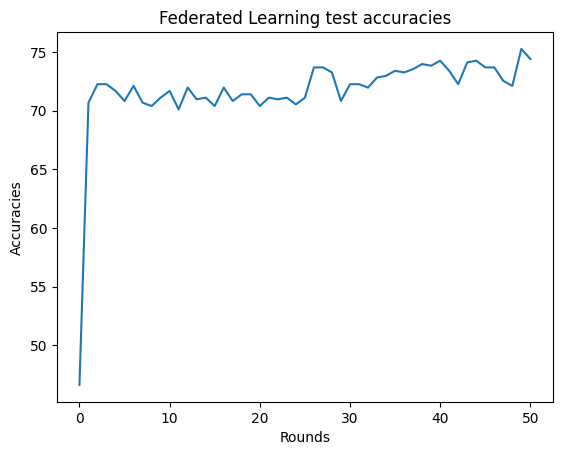

In [14]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [15]:
max(fl_acc)

tensor(75.2504, device='cuda:0')

# Transfer Learning

In [16]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "Transfer Learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.0,
    "learning_rate_TL": 0.0001,
    "batch_size_TL": 64,
    "decay_TL":1e-5,
    'num_rounds_TL': 40, 
    'epochs_TL': 100,
    'dropout_TL': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


FL accuracy,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇███████▇████▇█
FL loss,█▅▂▁▁▂▂▂▂▂▂▂▃▂▂▂▃▂▃▃▃▂▂▃▂▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂
FL accuracy,74.39199
FL loss,0.05336



Epoch 1/100
Epoch 1: Training accuracy: 50.64102554321289 Testing accuracy: 48.71794891357422.

Epoch 2/100
Epoch 2: Training accuracy: 63.78205108642578 Testing accuracy: 55.128204345703125.

Epoch 3/100
Epoch 3: Training accuracy: 67.54808044433594 Testing accuracy: 58.33333206176758.

Epoch 4/100
Epoch 4: Training accuracy: 69.63140869140625 Testing accuracy: 59.61538314819336.

Epoch 5/100
Epoch 5: Training accuracy: 71.15384674072266 Testing accuracy: 60.25640869140625.

Epoch 6/100
Epoch 6: Training accuracy: 72.91666412353516 Testing accuracy: 60.89743423461914.

Epoch 7/100
Epoch 7: Training accuracy: 74.19871520996094 Testing accuracy: 60.89743423461914.

Epoch 8/100
Epoch 8: Training accuracy: 75.88140869140625 Testing accuracy: 61.53845977783203.

Epoch 9/100
Epoch 9: Training accuracy: 77.24359130859375 Testing accuracy: 63.46154022216797.

Epoch 10/100
Epoch 10: Training accuracy: 75.64102935791016 Testing accuracy: 64.74359130859375.

Epoch 11/100
Epoch 11: Training accu

transfer training accuraccy,▁▄▅▆▆▇▇▇▇▇▇▇▇███▇███████████████████████
transfer validation accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██▇▇██▇█▇▆▇██
transfer training accuraccy,85.73718
transfer validation accuracy,80.76923


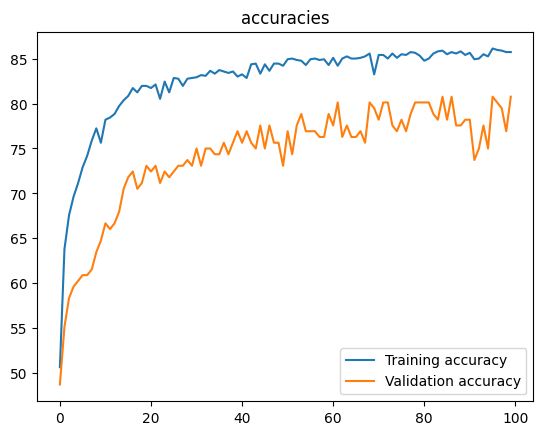

In [17]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration, configuration['epochs'], name= "transfer")
    loss, accuracy = test(net, azure_val_loaders_transfer, configuration)
    losses_transfer.append(loss)
    accuracies_transfer.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

# Federated Transfer Learning

wandb.init(
    # set the wandb project where this run will be logged
    project="FTL one class",
    name= "federated transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.0,
    "learning_rate_TL": 0.0001,
    "batch_size_TL": 64,
    "decay_TL":1e-5,
    'num_rounds_TL': 40, 
    'epochs_TL': 100,
    'dropout_TL': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

In [18]:
net_FTL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FTL, parameters_centralized)

In [19]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FTL, trainloader, valloader, configuration).to_client()


In [20]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
ftl_acc = []
def evaluate(server_round,parameters,config):
    testloader = azure_test_loader
    set_parameters(net_FTL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FTL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    ftl_acc.append(accuracy)
    metrics = {'FTL loss': loss,
               "FTL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FTL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-17 21:28:21,706	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'GPU': 2.0, 'node:192.168.1.146': 1.0, 'memory': 112027538842.0, 'object_store_memory': 52297516646.0, 'CPU': 32.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.06892872940410268 / accuracy 46.63805389404297


RuntimeError: Simulation crashed.

In [ ]:
f = []
for i in ftl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [ ]:
max(ftl_acc)